# Context

Recent studies have shown that breast cancer continues to be the leading cause of death among women over the world. If detected at an early stage, it can be cured in 9 out of 10 cases.

Automated detection and segmentation of cells from images are the crucial and fundamental steps for the measurement of cellular morphology that is crucial for brest cancer diagnosis and prognosis.


In this notebook, you will learn how to train a segmentation as UNet with **monai** - a framwork based Pytorch Stadard for healthcare imaging.

## Monai

MONAI is a pytorch based open source AI framework launched by NVIDIA and King’s College London.
It is integrated with training and modelling workflows in a native PyTorch Standard. t several places.


Install monai

In [3]:
# pip install monai

Check the installation by running the following cell

In [1]:
import monai
monai.config.print_config()

2024-10-26 22:07:08.405217: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-26 22:07:08.413389: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-26 22:07:08.424863: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-26 22:07:08.424885: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-26 22:07:08.432264: I tensorflow/core/platform/cpu_feature_gua

MONAI version: 1.4.0
Numpy version: 1.26.4
Pytorch version: 2.5.0+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: /home/<username>/anaconda3/envs/mlbio/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: 1.14.1
Pillow version: 11.0.0
Tensorboard version: 2.16.2
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: NOT INSTALLED or UNKNOWN VERSION.
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 6.1.0
pandas version: 2.2.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOW

In [9]:
import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

#  Dataset

To train a model, we need to prepare some ingredients:

1. Dataset
2. Model
3. Loss function
4. Optimizer

# I. Create Dataset

There are two ways to create your dataset:
- with pytorch Dataset
- with monai.data.Dataset.

In this exercise, we will create our dataset using torch.utils.data.Dataset.

## 1. List all files in folder

Download the dataset from https://zenodo.org/record/1175282#.YMn_Qy-FDox

Notice that there are two kind of folder : original cell picture folder and mask folders. Using your file explorer or some code, display one image and the corresponding image

Text(0.5, 1.0, 'Mask Image')

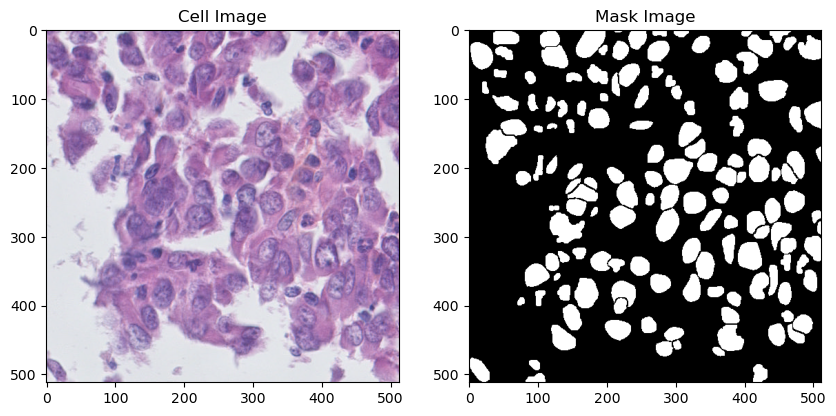

In [3]:
cell_pic_path = glob.glob('TNBC_NucleiSegmentation/Slide_04/04_4.png')
mask_pic_path = glob.glob('TNBC_NucleiSegmentation/GT_04/04_4.png')

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(plt.imread(cell_pic_path[0]))
ax[0].set_title('Cell Image')
ax[1].imshow(plt.imread(mask_pic_path[0]), cmap='gray')
ax[1].set_title('Mask Image')

## 2. Define a transform
When you load your data, you need to define some transformation. For example, we want to convert image to the format [num_channels, spatial_dim_1, spatial_dim_2] because monai/pytorch use this format. We'll also need to convert the images to PyTorch tensors with transforms.ToTensor()

The following code lets you load image and the labels and define several steps to transform the data.


In [52]:
import torch

from monai.transforms import Compose, LoadImage, EnsureChannelFirst, ToTensor, NormalizeIntensity
from monai.transforms import ScaleIntensity

from monai.data import PILReader

image_trans = Compose(
    [
        LoadImage(image_only=True, reader = PILReader(converter=lambda image: image.convert("RGB"))),
        EnsureChannelFirst(),
        NormalizeIntensity(),
        ToTensor(),
    ])


label_trans = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        ScaleIntensity(),
        ToTensor(),
    ])


## 3. Create dataset

The following class CellDataset allows us to create our dataset from "image_files" and "label_files" where:
- "image_files" is a list of image names
- "label_files" is the list of segmentation names respectively.

"im_trans" and "label_trans" are respectively the transforms for the images and their labels.




In [6]:
import torch

class CellDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, label_files, im_trans, label_trans):
        self.image_files = image_files
        self.label_files = label_files
        self.im_trans = im_trans
        self.label_trans = label_trans

    def __len__(self):
        return(len(self.image_files))

    def __getitem__(self, index):
        return self.im_trans(self.image_files[index]), self.label_trans(self.label_files[index])



By using this class, create your training dataset et your test dataset. Remember to check if your dataset is loaded correctly.

In [61]:
image_files = glob.glob('TNBC_NucleiSegmentation/Slide_*/*.png')
seg_files = glob.glob('TNBC_NucleiSegmentation/GT_*/*.png')
image_files.sort()
seg_files.sort()

df = pd.DataFrame({'image_files': image_files, 'seg_files': seg_files})

from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

df.head()

,image_files,seg_files
0,TNBC_NucleiSegmentation/Slide_01/01_1.png,TNBC_NucleiSegmentation/GT_01/01_1.png
1,TNBC_NucleiSegmentation/Slide_01/01_2.png,TNBC_NucleiSegmentation/GT_01/01_2.png
2,TNBC_NucleiSegmentation/Slide_01/01_3.png,TNBC_NucleiSegmentation/GT_01/01_3.png
3,TNBC_NucleiSegmentation/Slide_01/01_4.png,TNBC_NucleiSegmentation/GT_01/01_4.png
4,TNBC_NucleiSegmentation/Slide_01/01_5.png,TNBC_NucleiSegmentation/GT_01/01_5.png


In [62]:
train_dataset = CellDataset(train_df['image_files'].tolist(), train_df['seg_files'].tolist(), image_trans, label_trans)
test_dataset = CellDataset(test_df['image_files'].tolist(), test_df['seg_files'].tolist(), image_trans, label_trans)

## 4. DataLoader

With the your dataset loaded, you have to pass it to a DataLoader. The torch.utils.data.DataLoader takes a dataset and returns batches of images and the corresponding labels. You can set various parameters like the batch size and if the data is shuffled after each epoch.


The following code let you create a data loader for the train dataset, do the same to create a test_loader on the test_dataset. Name it **test_load**


In [63]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False)

## 5. Now, time to check your dataloader.

Execute the code following to check if your dataloader works correctly

In [64]:
import monai
im, seg = monai.utils.misc.first(train_loader)
im.shape

torch.Size([2, 3, 512, 512])

# II. Build your segmentation model with monai

Monai already has a UNet model architecture : https://docs.monai.io/en/stable/networks.html#unet

By using the monai.networks.nets module, build a UNet model for segmentation task in 2D. You'll have to choose the following parameters for the model:

1. dimensions (number of spatial dimensions)
2. in_channels (number of input channel)
3. out_channels (number of output channel)
4. channels
5. strides


In [65]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = monai.networks.nets.UNet(
    spatial_dims=2,
    in_channels=3,
    out_channels=1,
    channels=(4, 8, 16),
    strides=(2, 2),
).to(device)

# III. Define your loss function and optimizer

For a segmentation prob, we usually use DiceLoss.
Using monai.losses.DiceLoss, define your loss function and store it in the variable named **loss_function**. The option sigmoid = True should be used.




In [66]:
loss_function = monai.losses.DiceLoss(sigmoid=True)

With torch.optim, define an optimizer for your model. Use the Adam optimiser

In [67]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# IV. Trainning the model

This time, we have all ingredients to train a segmentation model: a model, an optimizer, train_loader and a loss function.  

Monai use a standard PyTorch program style for training a deep learning model.


The general process with Monai/Pytorch just for one learning step  as follows:

1. Load input and label of each batch.

2. Zero accumulated gradients with optimizer.zero_grad()

3. Compute the output from the model

4. Calculate the loss

5. Perform backprop with loss.backward()

6. Update the optimizer with optimizer.step()


Complete the following code so that it do the training


In [68]:
epoch_loss_values = list()
for epoch in range(2):

    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()

        #compute the model predictions using the model variable and inputs
        predictions = model(inputs)

        # compute the loss using the loss function, the predictions and labels
        assert predictions.shape == labels.shape, f"{predictions.shape} != {labels.shape} with {inputs.shape}"
        loss = loss_function(predictions, labels)

        # use the backward method of the loss variable to  compute the gradient of the loss used to find the minimum of the loss function

        # call the step method of the optimizer
        optimizer.step()

        epoch_loss += loss.item()
        epoch_len = len(train_dataset) // train_loader.batch_size
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")


    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")


1/20, train_loss: 0.8906
2/20, train_loss: 0.8164
3/20, train_loss: 0.7020
4/20, train_loss: 0.7871
5/20, train_loss: 0.8516
6/20, train_loss: 0.9061
7/20, train_loss: 0.6503
8/20, train_loss: 0.6745
9/20, train_loss: 0.8263
10/20, train_loss: 0.7880
11/20, train_loss: 0.7401
12/20, train_loss: 0.7701
13/20, train_loss: 0.7543
14/20, train_loss: 0.7826
15/20, train_loss: 0.7691
16/20, train_loss: 0.7577
17/20, train_loss: 0.7401
18/20, train_loss: 0.7846
19/20, train_loss: 0.8981
20/20, train_loss: 0.9673
epoch 1 average loss: 0.7928
1/20, train_loss: 0.7928
2/20, train_loss: 0.9103
3/20, train_loss: 0.9122
4/20, train_loss: 0.9337
5/20, train_loss: 0.8225
6/20, train_loss: 0.7401
7/20, train_loss: 0.7379
8/20, train_loss: 0.6910
9/20, train_loss: 0.7594
10/20, train_loss: 0.8910
11/20, train_loss: 0.8935
12/20, train_loss: 0.6322
13/20, train_loss: 0.6961
14/20, train_loss: 0.8898
15/20, train_loss: 0.7647
16/20, train_loss: 0.6934
17/20, train_loss: 0.6794
18/20, train_loss: 0.8057
1

Display the prediction of your model on several image

In [84]:
import os
# evaluate the model on the test dataset
k = 0
for batch_data in test_loader:
    inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
    predictions = model(inputs)
    
    # save the predictions and labels as images in the output folder
    for i in range(len(predictions)):
        if not os.path.exists("output"):
            os.makedirs("output")
        plt.imsave(f"output/prediction_{k}.png", predictions[i, 0].detach().cpu().numpy(), cmap='gray')
        plt.imsave(f"output/label_{k}.png", labels[i, 0].detach().cpu().numpy(), cmap='gray')
        k += 1

Text(0.5, 1.0, 'Label')

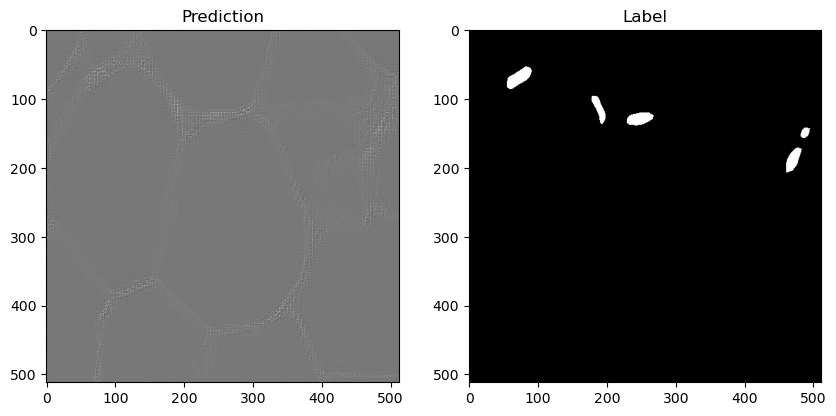

In [87]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(predictions[0, 0].detach().cpu().numpy(), cmap='gray')
ax[0].set_title('Prediction')
ax[1].imshow(labels[0, 0].detach().cpu().numpy(), cmap='gray')
ax[1].set_title('Label')

Train another architecture (either another Unet architecture or find another segmentation model in the available models of Monai). Compare the results with the first model

1/20, train_loss: 0.9016
2/20, train_loss: 0.6344
3/20, train_loss: 0.8521
4/20, train_loss: 0.8852
5/20, train_loss: 0.8954
6/20, train_loss: 0.9371
7/20, train_loss: 0.7366
8/20, train_loss: 0.8300
9/20, train_loss: 0.8707
10/20, train_loss: 0.8130
11/20, train_loss: 0.7971
12/20, train_loss: 0.6882
13/20, train_loss: 0.8593
14/20, train_loss: 0.6895
15/20, train_loss: 0.8255
16/20, train_loss: 0.8134
17/20, train_loss: 0.6685
18/20, train_loss: 0.8113
19/20, train_loss: 0.9449
20/20, train_loss: 0.8891
epoch 1 average loss: 0.8172
1/20, train_loss: 0.8481
2/20, train_loss: 0.8863
3/20, train_loss: 0.8130
4/20, train_loss: 0.8863
5/20, train_loss: 0.7487
6/20, train_loss: 0.8055
7/20, train_loss: 0.9543
8/20, train_loss: 0.8223
9/20, train_loss: 0.8324
10/20, train_loss: 0.8677
11/20, train_loss: 0.7442
12/20, train_loss: 0.8550
13/20, train_loss: 0.8888
14/20, train_loss: 0.6719
15/20, train_loss: 0.8214
16/20, train_loss: 0.7212
17/20, train_loss: 0.6426
18/20, train_loss: 0.8011
1

Text(0.5, 1.0, 'Label')

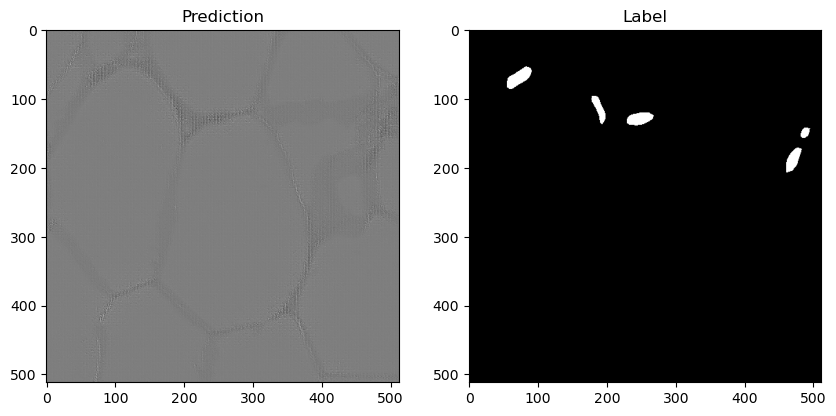

In [89]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = monai.networks.nets.UNet(
    spatial_dims=2,
    in_channels=3,
    out_channels=1,
    channels=(4, 8, 16, 32, 64),
    strides=(2, 2, 2, 2),
).to(device)
loss_function = monai.losses.DiceLoss(sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

epoch_loss_values = list()
for epoch in range(10):

    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()

        #compute the model predictions using the model variable and inputs
        predictions = model(inputs)

        # compute the loss using the loss function, the predictions and labels
        assert predictions.shape == labels.shape, f"{predictions.shape} != {labels.shape} with {inputs.shape}"
        loss = loss_function(predictions, labels)

        # use the backward method of the loss variable to  compute the gradient of the loss used to find the minimum of the loss function

        # call the step method of the optimizer
        optimizer.step()

        epoch_loss += loss.item()
        epoch_len = len(train_dataset) // train_loader.batch_size
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")


    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

import os
# evaluate the model on the test dataset
k = 0
for batch_data in test_loader:
    inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
    predictions = model(inputs)
    
    # save the predictions and labels as images in the output folder
    for i in range(len(predictions)):
        if not os.path.exists("output"):
            os.makedirs("output")
        plt.imsave(f"output/prediction_{k}.png", predictions[i, 0].detach().cpu().numpy(), cmap='gray')
        plt.imsave(f"output/label_{k}.png", labels[i, 0].detach().cpu().numpy(), cmap='gray')
        k += 1
        
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(predictions[0, 0].detach().cpu().numpy(), cmap='gray')
ax[0].set_title('Prediction')
ax[1].imshow(labels[0, 0].detach().cpu().numpy(), cmap='gray')
ax[1].set_title('Label')